## This page is under development...

I'm using yfinance package to download the stock data from yahoo finance. Then I will try predicting the prices for each stock. My goal is to make a prediction on the expected value and variance of the price based on the previous values. Then I'll try to compute the experimental covarience between different stocks and input them to an optimization problem designed to reduce the mixed variance while maximizing the expected output. This is based on the mean-volatility predicate in financial analysis.  
My initial intention was to use the rather new *tensorflow probability* capability to estimate the mean a variance for each output point. After some trials and failings, I have decided to use a simpler approach:
 - Use a small Nueral Net to compute a predicted value for the next days opening price for each stock.
 - Assume that my predictor assumes a normal distribution around the observed values (I should check this!). Therefore I can use the unbiased estimator of SD to find the expected variance around my predicted price.
 - Compute the correlations between different stocks experimentally (i.e. pairwise correlation between data columns)
 - perform the optimization as before.

In [1]:
import importlib
import single_stock_predictor
importlib.reload(single_stock_predictor)
import pickle
import yfinance as yf
import pandas as pd
import tensorflow as tf
import pickle
import numpy as np
#import mdn
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import h5py
from scipy.optimize import minimize

%matplotlib notebook

If running for first time, you need to downloaded the stock symbols or "tickers". This is in done by setting parameter  "get_tickers".<br> Currently I'm downloading the daily data for 9years. If you already have downloaded some part of the data you can download the rest and append them to each other. Later I hope to automatize this section, since my goal is to run this script once weekly or so.

In [2]:
get_tickers = False 
read_tickers = False
get_histories = False
get_updated_data = False
read_data = False
read_updated_data = True
get_business_info = False #you can go through business info field to exlude companies you don't want to invest in
if get_updated_data or get_business_info:
    read_tickers = True

In [3]:
def download_tickers():
    !curl -o /Users/abnousa/software/smartop/nasdaqtraded_companylist.txt ftp://ftp.nasdaqtrader.com/symboldirectory/nasdaqtraded.txt
    symbols = pd.read_csv("/Users/abnousa/software/smartop/nasdaqtraded_companylist.txt", sep = "|")
    symbols = symbols.iloc[0:(symbols.shape[0] - 1),:] #last row is time
    tickers = {}
    failed = []
    for i in symbols.index:
        sym = symbols.iloc[i]['Symbol']
        ticker = yf.Ticker(sym)
        try:
            check = ticker.calendar
        except Exception as e:
            print(' '.join(["disregarding", sym, type(e).__name__]))
            failed.append(sym)
            continue
        print(' '.join([sym, 'added']))
        name = symbols.iloc[i]['Security Name']
        tickers[sym] = {'name': name, 'ticker': ticker}
    sym_data = {'tickers':tickers, 'failed':failed}
    with open('sym_data.pkl', 'wb') as symfile:
        pickle.dump(sym_data, symfile)
    return(sym_data)
if get_tickers:
    sym_data = download_tickers()

In [4]:
#read_tickers = True
if read_tickers:
    with open('sym_data.pkl', 'rb') as symfile:
        sym_data = pickle.load(symfile)
        tickers, failed = sym_data['tickers'], sym_data['failed']

In [5]:
def download_business_info(tickers):
    for ticker in tickers.keys():
        #print(ticker)
        tickers[ticker]['business_summary'] = tickers[ticker]['ticker'].info.get('longBusinessSummary', None)
    with open('sym_data.pkl', 'wb') as symfile:
        pickle.dump(sym_data, symfile)
if get_business_info:
    download_business_info(tickers)

In [6]:
def download_histories(tickers):
    period = "9y"
    d = download_ticker_histories(tickers, period = period, interval = "1d", columns = ['Open'])
    with open("daily_history_9y.pkl", 'wb') as histfile:
        pickle.dump(d, histfile)
    return d
if get_histories:
    d = download_histories(sym_data['tickers'])

In [7]:
def download_ticker_histories(tickers, start = None, period = None, end = None, interval = "1d", columns = ['Open']):
    msft = yf.Ticker("MSFT")
    if start is None:
        temp_hist = msft.history(period="9y", interval="1d")
        end = list(temp_hist.index)[-1]
        start = list(temp_hist.index)[0]
    else:
        #print("downloading from", start)
        temp_hist = msft.history(start = start, interval = "1d")
        #print(temp_hist)
        end = list(temp_hist.index)[-1] 
        end = None
        #print(end + 1)
    d = yf.download(" ".join(list(tickers.keys())), start = last_date, end = end, interval = '1d', threads = False)[columns]
    return d

In [8]:
if read_data:
    with open("daily_history_9y.pkl", 'rb') as infile:
        d = pickle.load(infile)

In [9]:
def update_data(d, tickers, columns = ['Open']):
    last_date = (pd.to_datetime(d.index.values[-1])).strftime("%Y-%m-%d")
    d_update = download_ticker_histories(tickers, start = last_date, interval = "1d", columns = columns)
    d_update = d_update.iloc[1:,:]
    #d_update.head()
    d_merged = pd.concat([d, d_update], axis = 0)
    with open("daily_history_updated.pkl", 'wb') as histfile:
        pickle.dump(d_merged, histfile)
    return d_merged
if get_updated_data:
    d = update_data(d, tickers, columns = ['Open'])

In [10]:
if read_updated_data:
    with open("daily_history_updated.pkl", 'rb') as infile:
        d = pickle.load(infile)

(array([4166.,   28.,   25.,   52.,   18.,   23.,   22.,    9.,   23.,
          24.,   21.,   10.,   56.,   23.,   39.,   21.,   13.,   26.,
          14.,   32.,   27.,   13.,   14.,   28.,   21.,   36.,   26.,
          27.,   34.,   16.,   47.,   60.,   24.,   24.,   40.,   38.,
          37.,   37.,   56.,   39.,   22.,   53.,   48.,   30.,   24.,
          34.,   35.,   19.,   41.,   51.,   45.,   23.,   40.,   38.,
          27.,   31.,   14.,   22.,   39.,   30.,   33.,   29.,   23.,
          59.,   32.,   24.,   39.,   27.,   20.,   28.,   42.,   52.,
          46.,   25.,   45.,   84.,   52.,   46.,   57.,   30.,   54.,
          42.,   53.,   46.,   37.,   70.,   60.,   40.,   31.,   35.,
          41.,   69.,   55.,   39.,   37.,   18.,   56.,   38.,   43.,
          19.]),
 array([   0.  ,   22.77,   45.54,   68.31,   91.08,  113.85,  136.62,
         159.39,  182.16,  204.93,  227.7 ,  250.47,  273.24,  296.01,
         318.78,  341.55,  364.32,  387.09,  409.86,  432.63

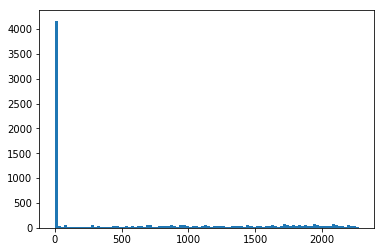

In [11]:
plt.figure()
plt.hist(d.isna().sum(), bins = 100)

In [12]:
#backward-filling na's 
d = d.iloc[:, list(np.where(d.isna().sum() < 20)[0])]
d = d.fillna(method = "bfill")
d.shape

(2277, 4164)

In [13]:
#removing rows where the latest price is na
d = d.loc[:, ~(d.iloc[d.shape[0] - 1,:].isna())]
d.shape

(2277, 4090)

In [79]:
import single_stock_predictor
importlib.reload(single_stock_predictor)

<module 'single_stock_predictor' from '/Users/abnousa/software/smartr/single_stock_predictor.py'>

In [14]:
stock_name = "BMRA"
weekly = False
window_size = 30
batch_size = 32
shuffle_buffer = None
distributional = False
epochs = 10
training_points = 1500
model_sd_estimate_required = True
model_outdir = "models"
training_verbosity = 1
look_ahead_window = 5
pred, train_sd, valid_sd, model_train_sd, train_forecasts, model_valid_sd, valid_forecasts = single_stock_predictor.predict_tomorrow(stock_name, d, model_outdir = model_outdir, weekly = weekly, training_points = training_points, window_size = window_size, batch_size = batch_size, distributional = distributional, epochs = epochs, model_sd_estimate_required = model_sd_estimate_required, shuffle_buffer = shuffle_buffer, training_verbosity = training_verbosity, look_ahead_window = look_ahead_window)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 30, 128)           16640     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 128)               32896     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 49,665
Trainable params: 49,665
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
46/46 [==============================] - 5s 102ms/step - loss: 0.0616 - val_loss: 0.0000e+00
Epoch 2/10
46/46 [==============================] - 1s 27ms/step - loss: 0.0150 - val_loss: 0.0658
Epoch 3/10
46/46 [==============================] - 1s 27ms/step - loss: 0.0130 - val_loss: 0.0523
Epoch 4/10
46/46 [==============================] - 1s 26ms/step - loss: 0.0140 

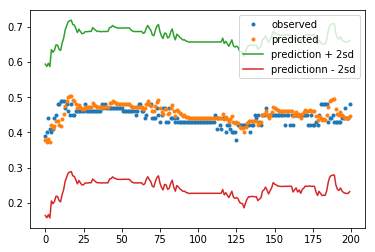

In [15]:
plt.figure()
single_stock_predictor.plot_predictions(d[stock_name], train_forecasts, model_train_sd, window_size, limit_begin = 0, limit_end = 200, look_ahead_window = look_ahead_window)

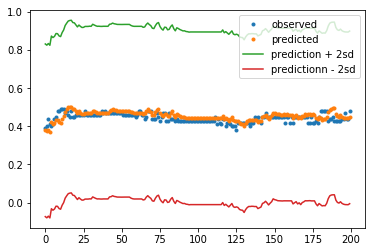

In [16]:
plt.figure()
single_stock_predictor.plot_predictions(d[stock_name], train_forecasts, model_valid_sd, window_size, limit_begin = 0, limit_end = 200, look_ahead_window = look_ahead_window)

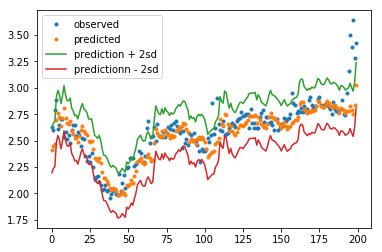

In [17]:
plt.figure()
single_stock_predictor.plot_predictions(d[stock_name][training_points:], valid_forecasts, model_train_sd, window_size, limit_begin = 0, limit_end = 200, look_ahead_window = look_ahead_window)

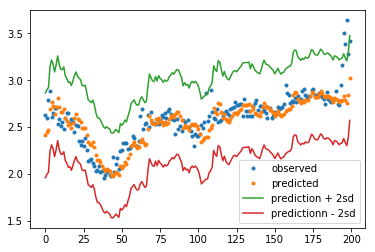

In [18]:
plt.figure()
single_stock_predictor.plot_predictions(d[stock_name][training_points:], valid_forecasts, model_valid_sd, window_size, limit_begin = 0, limit_end = 200, look_ahead_window = look_ahead_window)

okay, so far we have showed that for the specified stock (here, MSFT aka microsoft) our model generates rather dependable predictions of price and our estimated standard deviation seems to be fitting at least visually. Of course, one can argue that we have picked an easy ticker, you'd expect microsoft to have a stable price. Well, I can't argue against that. But now, I'm going to randomly pick 10 tickers and perform the same operation on each of them. Before that I
m going to use the *cov()* function from pandas to compute pairwise correlation between the selected tickers.

In [113]:
import random
ticker_set = random.sample(list(d.columns), 10)
ticker_set

['CGEN', 'EXK', 'SRT', 'SCHB', 'MO', 'GEL', 'EVRI', 'PMBC', 'IEO', 'CCCL']

In [114]:
d_select = d[ticker_set]
covariances = d_select.cov()
covariances.head()
correlations = d_select.corr()

<IPython.core.display.Javascript object>


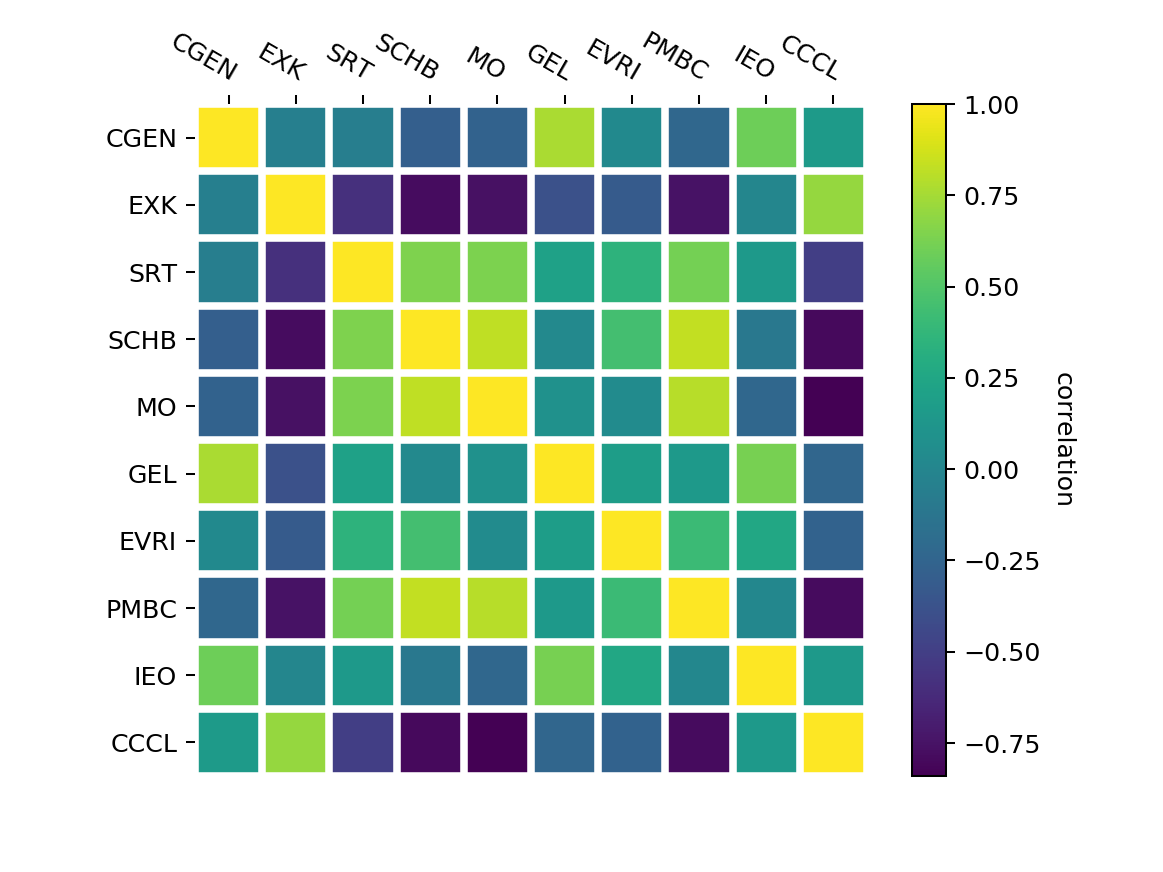

(<matplotlib.image.AxesImage at 0x14ee82470>,
 <matplotlib.colorbar.Colorbar at 0x14eeabac8>)

In [115]:
plt.figure()
corels_matrix = np.array(correlations)
single_stock_predictor.heatmap(corels_matrix, correlations.columns.values, correlations.columns.values, cbarlabel = "correlation")

In [112]:
weekly = False
window_size = 30
batch_size = 32
shuffle_buffer = None
distributional = False
epochs = 10
training_points = 1500
model_sd_estimate_required = True
model_outdir = "models"
look_ahead_window = 5
training_verbosity = 0

In [116]:
prediction_dict = {}
for stock_name in ticker_set:
    print(" ".join(["processing", stock_name]))
    pred, train_sd, valid_sd, model_train_sd, train_forecasts, model_valid_sd, valid_forecasts = single_stock_predictor.predict_tomorrow(stock_name, d, model_outdir = model_outdir, weekly = weekly, training_points = training_points, window_size = window_size, batch_size = batch_size, distributional = distributional, epochs = epochs, model_sd_estimate_required = model_sd_estimate_required, shuffle_buffer = shuffle_buffer, training_verbosity = training_verbosity, look_ahead_window = look_ahead_window)
    prediction_dict[stock_name] = {'expected_tomorrow': pred,
                                   'model_train_sd': model_train_sd,
                                   'train_forecasts': train_forecasts,
                                   'model_valid_sd': model_valid_sd,
                                   'valid_forecasts': valid_forecasts}
    current_price = d.iloc[d.shape[0]-1][stock_name]
    return_rate = pred / current_price - 1
    prediction_dict[stock_name]['return_rate'] = return_rate

processing CGEN
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 30, 128)           16640     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 128)               32896     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 49,665
Trainable params: 49,665
Non-trainable params: 0
_________________________________________________________________
processing EXK
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 30, 128)           16640     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 128)               32896     
_

It looks like for a few of the stocks, validation error was smaller than the training error. I'm curious why.

So here are the plots from validation data:

<IPython.core.display.Javascript object>


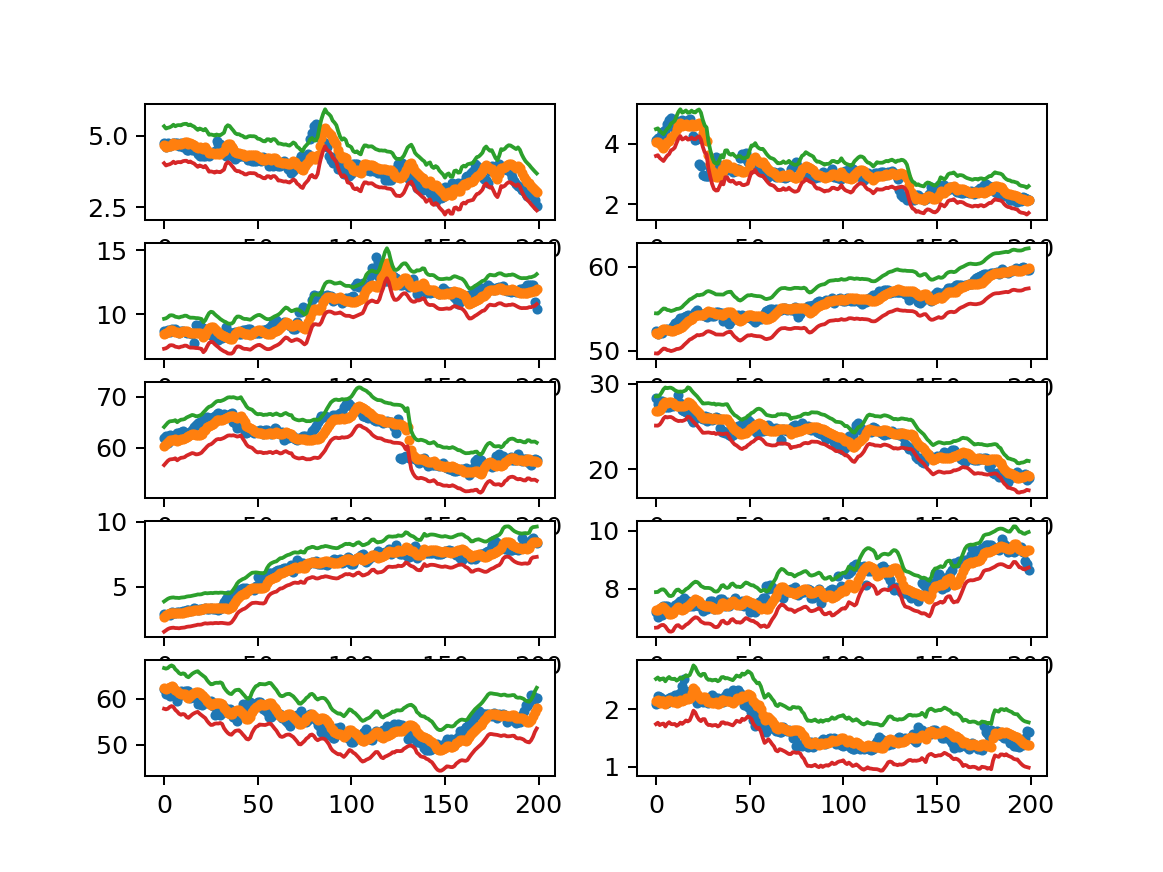

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


In [117]:
plt.figure()
plt.subplot(5,2,1)
for plt_index, stock_name in enumerate(ticker_set):
    ax = plt.subplot(5,2,plt_index + 1)
    single_stock_predictor.plot_predictions(d[stock_name][training_points:], prediction_dict[stock_name]['valid_forecasts'], prediction_dict[stock_name]['model_valid_sd'], window_size, limit_begin = 0, limit_end = 200, ax = ax, legend = False, look_ahead_window = look_ahead_window)        

and here are plots for training data:

<IPython.core.display.Javascript object>


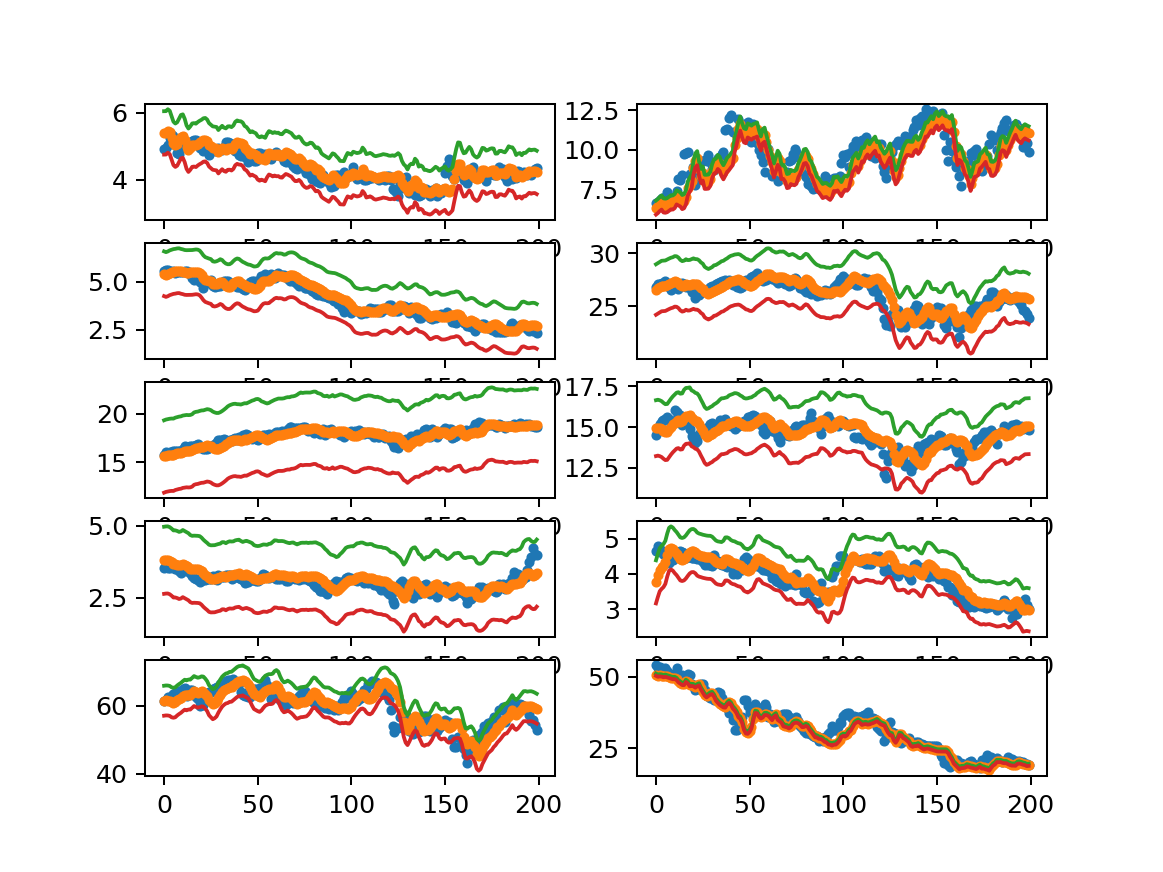

In [118]:
plt.figure()
plt.subplot(5,2,1)
for plt_index, stock_name in enumerate(ticker_set):
    ax = plt.subplot(5,2,plt_index + 1)
    single_stock_predictor.plot_predictions(d[stock_name], prediction_dict[stock_name]['train_forecasts'], prediction_dict[stock_name]['model_valid_sd'], window_size, limit_begin = 0, limit_end = 200, ax = ax, legend = False, look_ahead_window = look_ahead_window)

In [ ]:
for stock_name in ticker_set:
    pred = prediction_dict[stock_name]['expected_tomorrow']
    current_price = d.iloc[d.shape[0] - 1, :][stock_name]
    return_rate = pred / current_price - 1
    prediction_dict[stock_name]['return_rate'] = return_rate

In [ ]:
rat_risks = pd.DataFrame({'return_rate':[prediction_dict[stock_name]['return_rate'] for stock_name in ticker_set],
                        'risk' : [prediction_dict[stock_name]['valid_sd'] for stock_name in ticker_set],
                         'price': d.iloc[d.shape[0] - 1][ticker_set]})

In what follows I'll be minimzing the mixed variance by selecting the "best" portfolio for a given return rate and budjet. For the optimization part I have heavily been dependent on the codes in [this tutorial](https://towardsdatascience.com/efficient-frontier-optimize-portfolio-with-scipy-57456428323e). Kudos to **J Li**. I have modified the code to compute the portfolio risk from linear combination of standard deviations. Later I will also modify the optimization function by adding new constraints to compute the number of shares to buy with a given budget rather than the weight of instruments in the portfolio.

variance of a linear combination of random variable can be computed by the formula below: [(source)](https://en.wikipedia.org/wiki/Variance)
<img src="ext/lincomb_variance.png" style="height:200px">

In [19]:
#ticker_set = [name for name in candidates if name in list(d.columns.values)]
rat_risks = pd.read_csv("rates_and_risks.csv")
rat_risks.head()
rat_risks = rat_risks[rat_risks['name'] != "stock"]
print(rat_risks.shape)
rat_risks.head()

(529, 5)


,price,train_sd,name,valid_sd,prediction
0,87.720001,0.433837,A,0.776038,87.153267
1,27.959999,0.562441,AAL,0.677180,27.896721
2,1.920000,0.063776,AAME,0.081169,1.901032
3,50.740002,0.275293,AAON,0.578181,50.661316
4,310.600006,1.100437,AAPL,2.266835,310.403961


In [20]:
rat_risks['return_rate'] = (rat_risks['prediction'] - rat_risks['price'])/rat_risks['price']
rat_risks.head()

,price,train_sd,name,valid_sd,prediction,return_rate
0,87.720001,0.433837,A,0.776038,87.153267,-0.006461
1,27.959999,0.562441,AAL,0.677180,27.896721,-0.002263
2,1.920000,0.063776,AAME,0.081169,1.901032,-0.009879
3,50.740002,0.275293,AAON,0.578181,50.661316,-0.001551
4,310.600006,1.100437,AAPL,2.266835,310.403961,-0.000631


(array([  1.,   0.,   0.,   0.,   1., 468.,  46.,   5.,   4.,   4.]),
 array([-0.65485229, -0.53919516, -0.42353802, -0.30788089, -0.19222375,
        -0.07656662,  0.03909052,  0.15474765,  0.27040479,  0.38606192,
         0.50171906]),
 <a list of 10 Patch objects>)

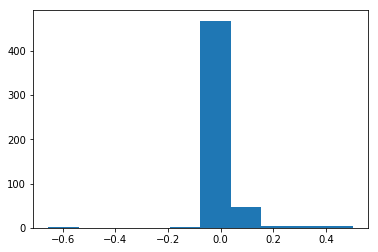

In [21]:
plt.hist(rat_risks['return_rate'])

In [22]:
ticker_set = rat_risks['name']
#rat_risks[rat_risks['return_rate']>3]

<IPython.core.display.Javascript object>


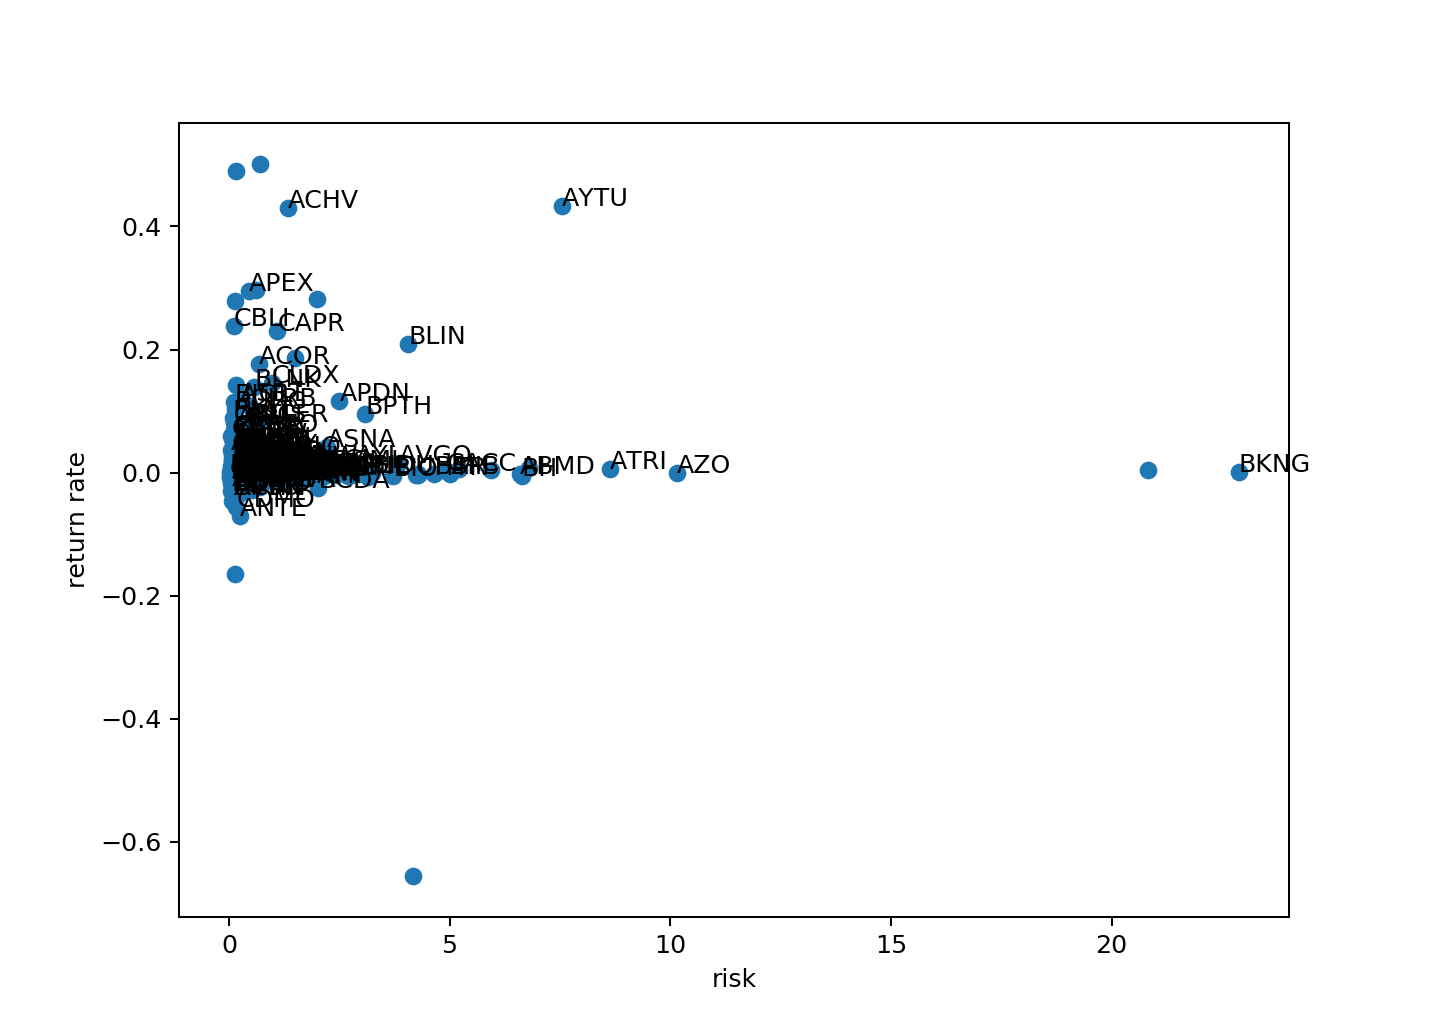

In [23]:
%matplotlib notebook
fig, ax = plt.subplots()
ax.scatter(rat_risks['valid_sd'], rat_risks['return_rate'])
for stock_name in ticker_set:
    ax.annotate(stock_name, (rat_risks[rat_risks['name'] == stock_name]['valid_sd'], rat_risks[rat_risks['name'] == stock_name]['return_rate']))
plt.xlabel("risk")
plt.ylabel("return rate")
plt.show()

In [27]:
def get_portfolio_risk(weights, rat_risks, covariances):
    weight_matrix = np.outer(weights , weights)
    weight_cov_combined = covariances * weight_matrix
    mixed_var = np.sum(np.sum(weight_cov_combined))
    return mixed_var

def get_portfolio_return(weights, rat_risks):
    total_return_rate = np.sum(rat_risks['return_rate'] * weights)
    return total_return_rate

In [30]:
def optimize_weights(rat_risks, target_return=0.1):
    instruments_count = rat_risks.shape[0]
    init_guess = np.zeros(instruments_count) * (1.0 / instruments_count)
    #print(init_guess)
    bounds = ((0.0, 1.0),) * instruments_count
    weights = minimize(get_portfolio_risk, init_guess,
                       args=(rat_risks, covariances), method='SLSQP',
                       options={'disp': False, 'maxiter' : 100},
                       constraints=({'type': 'eq', 'fun': lambda inputs: 1.0 - np.sum(inputs)},
                                    {'type': 'eq', 'args': (rat_risks,),
                                     'fun': lambda inputs, rat_risks:
                                     target_return - get_portfolio_return(weights=inputs,
                                                                          rat_risks=rat_risks)}
                                   ),
                       bounds=bounds)
    return weights.x, weights.success, weights.status, weights.message

In [29]:
d_select = d[rat_risks['name']]
covariances = d_select.cov()
weights, success, status, message = optimize_weights(rat_risks, target_return = 0.08)
print(get_portfolio_risk(weights, rat_risks, covariances))
print(success)
print(status)
print(message)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.06307657981276821
            Iterations: 34
            Function evaluations: 18111
            Gradient evaluations: 34
0.06307657981276821
True
0
Optimization terminated successfully.


In [34]:
results = pd.DataFrame()
for desired_rate in np.arange(0.01,0.21, 0.01):
    print(' '.join(['processing for return rate', str(desired_rate)]))
    weights, success, status, message = optimize_weights(rat_risks, target_return = desired_rate)
    cur_risk = get_portfolio_risk(weights, rat_risks, covariances)
    results = pd.concat([results, pd.DataFrame({'return': [desired_rate], 'risk': [cur_risk],
                                             'success': [success], 'message' : [message]})], axis = 0)

processing for return rate 0.01
processing for return rate 0.02
processing for return rate 0.03
processing for return rate 0.04
processing for return rate 0.05
processing for return rate 0.060000000000000005
processing for return rate 0.06999999999999999
processing for return rate 0.08
processing for return rate 0.09
processing for return rate 0.09999999999999999
processing for return rate 0.11
processing for return rate 0.12
processing for return rate 0.13
processing for return rate 0.14
processing for return rate 0.15000000000000002
processing for return rate 0.16
processing for return rate 0.17
processing for return rate 0.18000000000000002
processing for return rate 0.19
processing for return rate 0.2


In [35]:
results

,return,risk,success,message
0,0.01,0.003416,True,Optimization terminated successfully.
0,0.02,0.005210,True,Optimization terminated successfully.
0,0.03,0.008674,True,Optimization terminated successfully.
0,0.04,0.014089,True,Optimization terminated successfully.
0,0.05,0.021489,True,Optimization terminated successfully.
0,0.06,0.031090,True,Optimization terminated successfully.
0,0.07,0.044295,True,Optimization terminated successfully.
0,0.08,0.063077,True,Optimization terminated successfully.
0,0.09,0.089456,True,Optimization terminated successfully.
0,0.10,0.123825,True,Optimization terminated successfully.


<IPython.core.display.Javascript object>


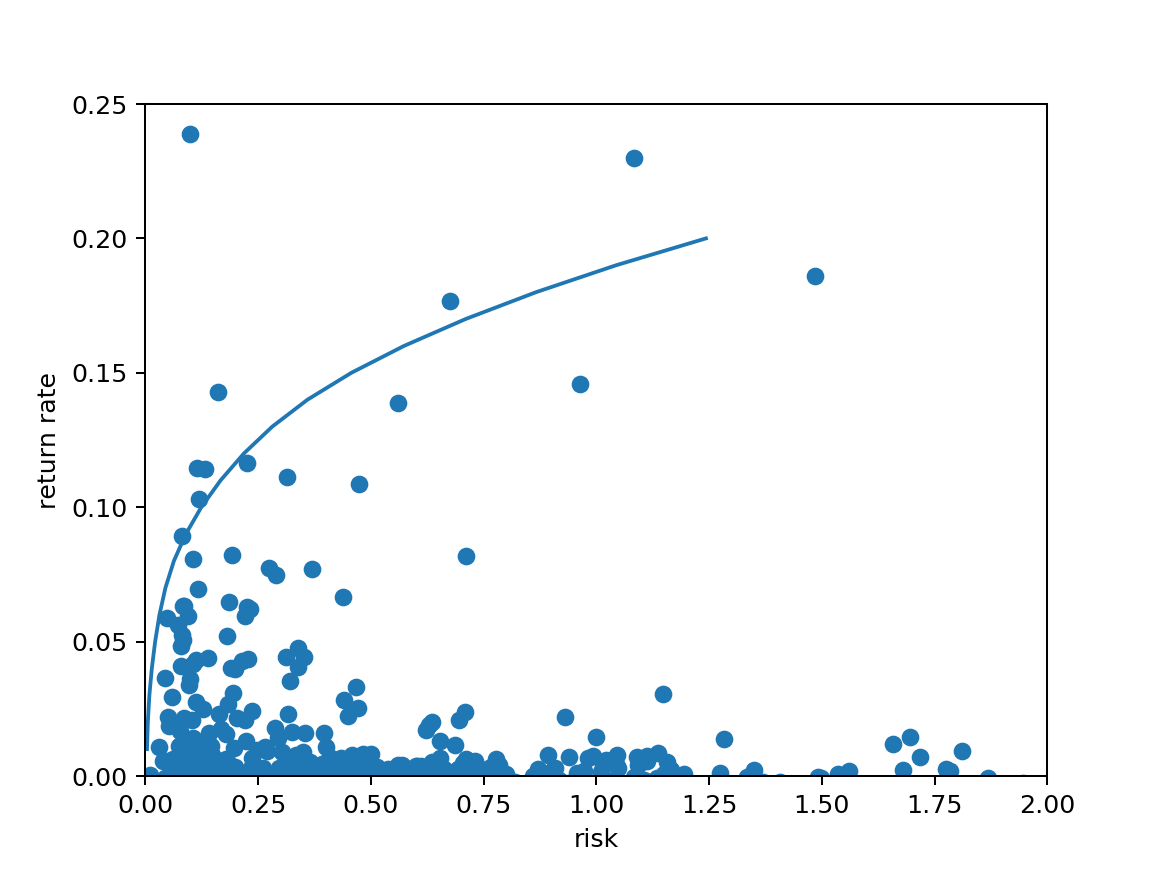

In [38]:
fig, ax = plt.subplots()
ax.scatter(rat_risks['valid_sd'], rat_risks['return_rate'])
#for stock_name in ticker_set:
#    ax.annotate(stock_name, (rat_risks[rat_risks['name'] == stock_name]['valid_sd'], rat_risks[rat_risks['name'] == stock_name]['return_rate']))
plt.plot(results['risk'], results['return'])
plt.xlabel("risk")
plt.ylabel("return rate")
plt.ylim(0,0.25)
plt.xlim(0,2)
plt.show()

In [39]:
weights, success, status, message = optimize_weights(rat_risks, target_return = 0.075)

In [40]:
rat_risks['weights'] = weights

Now let's modify the optimization function to accept and budget constraint as well as output number of shares per instrument (integer) rather than weights.

In [47]:
def get_portfolio_risk_by_shares(shares, rat_risks, covariances):
    weights = shares / np.sum(shares)
    weight_matrix = np.outer(weights , weights)
    weight_cov_combined = covariances * weight_matrix
    mixed_var = np.sum(np.sum(weight_cov_combined))
    return mixed_var

def get_portfolio_return_by_shares(shares, rat_risks, budget):
    spent = np.sum(rat_risks['price'] * shares)
    unspent = budget - spent
    returns = spent * np.sum(rat_risks['return_rate'] * shares) + unspent
    total_return_rate = (returns/budget) - 1
    return total_return_rate

def budget_constraint_by_shares(shares, rat_risks, budget):
    prices = np.array(rat_risks['price'])
    unspent = budget - np.sum(shares * prices)
    return(unspent)

In [48]:
def optimize_shares(rat_risks, target_return=0.1, budget = 2000):
    #normalized_prices = prices / prices.ix[0, :]
    instruments_count = rat_risks.shape[0]
    init_guess = np.ones(instruments_count) #(1.0 / instruments_count)
    bounds = ((0.0, np.inf),) * instruments_count
    shares = minimize(get_portfolio_risk_by_shares, init_guess,
                       args=(rat_risks, covariances), method='SLSQP',
                       options={'disp': True, 'maxiter': 100},
                       constraints=({'type': 'ineq', 'fun': lambda x: budget_constraint_by_shares(x, rat_risks, budget)}, #make sure total is less than budget
                                    {'type': 'eq', 'args': (rat_risks, budget), #make the return rate equal to the expected rate
                                     'fun': lambda inputs, rat_risks, budget:
                                     target_return - get_portfolio_return_by_shares(inputs, rat_risks, budget)},
                                    {'type':'eq','fun': lambda x : max([0] + [x[i]-int(x[i]) for i in range(len(x)) if x[i]-int(x[i]) > 0])}, #try to make them as close to integer as possible
                                   ),
                       bounds=bounds
                     )
    return shares.x, shares.success, shares.status, shares.message

In [49]:
budget = 500
share_distribution, success, status, message = optimize_shares(rat_risks, budget = budget, target_return = 0.075)
rat_risks['shares'] = np.floor(share_distribution)

Iteration limit exceeded    (Exit mode 9)
            Current function value: 2.022261217639825
            Iterations: 101
            Function evaluations: 54089
            Gradient evaluations: 101


In [52]:
rat_risks.sort_values(['weights', 'price', 'shares'], ascending = False).head(20)

,price,train_sd,name,valid_sd,prediction,return_rate,weights,shares
170,0.535250,0.146977,BKYI,0.080529,0.583058,0.089320,0.302917,23.0
473,1.190000,0.148501,AHPI,0.072056,1.256893,0.056212,0.218026,6.0
163,87.650002,0.156422,BIV,0.136278,87.701500,0.000588,0.102073,0.0
366,0.800000,0.341985,ADMP,0.131198,0.891506,0.114382,0.085901,8.0
432,1.232300,0.201994,CUI,0.082099,1.296919,0.052438,0.040752,8.0
454,2.400000,0.171461,CYAN,0.096798,2.481270,0.033862,0.034362,0.0
67,18.760000,0.302449,ATV,0.601701,18.829119,0.003684,0.028365,0.0
390,0.390000,0.785509,CREG,0.139980,0.580866,0.489399,0.023829,0.0
221,38.099998,0.605153,CALM,0.622687,38.754486,0.017178,0.023029,0.0
360,0.405000,0.327047,CORV,0.118577,0.517779,0.278466,0.022762,0.0


In [54]:
rat_risks.sort_values(['return_rate','price'], ascending = False).head(20)

,price,train_sd,name,valid_sd,prediction,return_rate,weights,shares
475,0.7800,9.287163,AIM,0.703636,1.171341,0.501719,3.042327e-10,0.0
390,0.3900,0.785509,CREG,0.139980,0.580866,0.489399,2.382950e-02,0.0
95,0.8500,2257.414159,AYTU,7.545876,1.217860,0.432777,2.388444e-06,0.0
244,0.5720,24.217759,ACHV,1.329431,0.818277,0.430555,1.660086e-10,0.0
480,1.2600,0.646545,AKRX,0.596281,1.634494,0.297218,1.036827e-02,12.0
20,0.7800,1.017137,APEX,0.441831,1.010722,0.295797,3.109974e-10,0.0
372,1.1800,9.531489,ADXS,1.975093,1.512090,0.281432,3.151675e-11,0.0
360,0.4050,0.327047,CORV,0.118577,0.517779,0.278466,2.276241e-02,0.0
239,0.6083,1.646003,CBLI,0.099751,0.753513,0.238719,1.444356e-11,0.0
225,1.7800,7.552832,CAPR,1.083663,2.189015,0.229784,1.846211e-11,0.0


In [55]:
rat_risks.to_csv("rates_and_risks_with_weights_20200120.csv")

## draftpad: (nothing interesting below)

In [ ]:
h2 = hist.drop_duplicates(keep = 'last')

In [803]:
candidates = ['A', 'AAAU', 'AACG', 'AAL', 'AAMC', 'AAME', 'AAOI', 'AAON', 'AAPL', 'AAT', 'AAWW', 'AAXJ', 'ABB', 'ABBV',
             'ABC', 'ABDC', 'ABEO', 'ABEV', 'ABG', 'ABIO', 'ABM', 'ABMD', 'ABT', 'ABUS', 'ACAD', 'ACC', 'ACCO', 'ACEL', 
             'ACER', 'ACES', 'ACHC', 'ACHN', 'ACHV', 'ACIA', 'ACIU', 'ACIW', 'ACLS', 'ACM', 'ACMR', 'ACN', 'ACOR', 'ACRS',
             'ACRX', 'ACST', 'ACTG', 'ACU', 'ACY', 'ADAP', 'ADBE', 'ADI', 'ADIL', 'ADM', 'ADMA', 'ADMP', 'ADMS', 'ADNT', 
             'ADP', 'ADPT', 'ADRO', 'ADS', 'ADSK', 'ADSW', 'ADT', 'ADTN', 'ADUS', 'ADVM', 'ADXS', 'AEHR', 'AEMD', 'AEO', 
             'AER', 'AERI', 'AESE', 'AEY', 'AEYE', 'AEZS', 'AFI', 'AFMD', 'AFYA', 'AGCO', 'AGE', 'AGEN', 'AGFS', 'AGIO',
              'AGLE', 'AGN', 'AGRO', 'AGRX', 'AGS', 'AGTC', 'AGYS', 'AHC', 'AHCO', 'AHH', 'AHPI', 'AHT', 'AIH', 
              'AIHS', 'AIM', 'AIMC', 'AIMT', 'AIRG', 'AIRT', 'AIT', 'AIV', 'AJX', 'AKBA', 'AKCA', 'AKER', 'AKRO',
              'AKRX', 'AKTS', 'AKTX', 'AL', 'ALB', 'ALBO', 'ALC', 'ALCO', 'ALDX', 'ALEC', 'ALEX', 'ALG', 'ALGN', 
              'ALGT', 'ALIM', 'ALJJ', 'ALK', 'ALKS', 'ALLE', 'ALLK', 'ALLO', 'ALLT', 'ALNA', 'ALNY', 'ALOT', 'ALPN',
              'ALRM', 'ALRN', 'ALRS', 'ALSK', 'ALT', 'ALTR', 'ALV', 'ALX', 'ALXN', 'ALYA', 'AMAG', 'AMAT', 'AMBA',
              'AMBO', 'AMC', 'AMCR', 'AMCX', 'AMD', 'AME', 'AMED', 'AMEH', 'AMGN', 'AMH', 'AMK', 'AMKR', 'AMN', 
              'AMOT', 'AMOV', 'AMPE', 'AMPH', 'AMRC', 'AMRH', 'AMRS', 'AMRX', 'AMS', 'AMSC', 'AMSWA', 'AMT', 'AMTX',
              'AMWD', 'AMX', 'AMZN', 'ANAB', 'ANCN', 'ANDE', 'ANET', 'ANF', 'ANFI', 'ANGI', 'ANGO', 'ANIK', 'ANIP',
              'ANIX', 'ANSS', 'ANTE', 'ANY', 'AOS', 'AOSL', 'AP', 'APA', 'APD', 'APDN', 'APEI', 'APEN', 'APEX', 
              'APH', 'APLE', 'APLS', 'APLT', 'APM', 'APO', 'APOG', 'APOP', 'APPF', 'APPN', 'APPS', 'APRE', 'APRN', 'APT',
              'APTO', 'APTS', 'APTV', 'APTX', 'APVO', 'APWC', 'APYX', 'AQB', 'AQMS', 'AQST', 'AQUA', 'ARA', 'ARAV',
              'ARAY', 'ARC', 'ARCE', 'ARCO', 'ARCT', 'ARD', 'ARDS', 'ARDX', 'ARE', 'AREC', 'ARGX', 'ARI', 'ARKF', 'ARKG',
              'ARKR', 'ARKW', 'ARL', 'ARLO', 'ARMK', 'ARMP', 'ARNA', 'ARNC', 'ARPO', 'ARQL', 'ARR', 'ARTL', 'ARTNA', 'ARTW',
              'ARTX', 'ARVN', 'ARW', 'ARWR', 'ARYA', 'ASGN', 'ASH', 'ASLN', 'ASMB', 'ASML', 'ASNA', 'ASND', 'ASPN',
              'ASPU', 'ASR', 'ASRT', 'ASTC', 'ASTE', 'ASUR', 'ASX', 'ASYS', 'ATAX', 'ATEC', 'ATEN', 'ATEX', 'ATGE', 'ATHE', 
              'ATHM', 'ATHX', 'ATI', 'ATIF', 'ATKR', 'ATNI', 'ATNM', 'ATNX', 'ATOM', 'ATOS', 'ATR', 'ATRA', 'ATRC', 'ATRI', 
              'ATRS', 'ATSG', 'ATTO', 'ATUS', 'ATV', 'ATVI', 'ATXI', 'AUDC', 'AUPH', 'AUTL', 'AUTO', 'AVA', 'AVB', 'AVCO',
              'AVD', 'AVDL', 'AVEO', 'AVGO', 'AVGR', 'AVID', 'AVLR', 'AVNS', 'AVNW', 'AVP', 'AVRO', 'AVT', 'AVTR', 'AVX',
              'AVXL', 'AVY', 'AVYA', 'AWI', 'AWK', 'AWR', 'AWRE', 'AWX', 'AXDX', 'AXE', 'AXGN', 'AXGT', 'AXL', 'AXLA',
              'AXNX', 'AXSM', 'AXTA', 'AXTI', 'AY', 'AYI', 'AYR', 'AYTU', 'AYX', 'AZN', 'AZO', 'AZPN', 'AZRE', 'AZRX', 
              'AZUL', 'AZZ', 'B', 'BA', 'BABA', 'BAH', 'BAND', 'BASI', 'BB', 'BBBY', 'BBC', 'BBCP', 'BBGI', 'BBI',
              'BBIO', 'BBP', 'BBQ', 'BBSI', 'BBW', 'BBX', 'BBY', 'BC', 'BCC', 'BCDA', 'BCE', 'BCEL', 'BCLI', 
              'BCO', 'BCOM', 'BCOR', 'BCOV','BCPC', 'BCRX', 'BCS', 'BCYC', 'BDC', 'BDL', 'BDN', 'BDR', 'BDRY',
              'BDSI', 'BDX', 'BE', 'BEAT', 'BECN', 'BEDU', 'BELFA', 'BELFB', 'BEN', 'BEP', 'BERY', 'BEST', 'BFAM',
              'BFRA', 'BG', 'BGVF', 'BGI', 'BGNE', 'BGS', 'BGSF', 'BH', 'BHAT', 'BHC', 'BHE', 'BHR', 'BHTG', 
              'BHVN', 'BIB', 'BIDU', 'BIG', 'BIIB', 'BIL', 'BILI', 'BILL', 'BIMI', 'BIO', 'BIOC', 'BIOL', 'BIOS',
              'BIOX', 'BIS', 'BITA', 'BIV', 'BJ', 'BJRI', 'BKD', 'BKE', 'BKH', 'BKI', 'BKNG', 'BKTI', 'BKYI',
              'BL', 'BLBD', 'BLCM', 'BLD', 'BLDP', 'BLDR', 'BLFS', 'BLIN', 'BLKB', 'BLL', 'BLMN', 'BLNK', 'BLOK',
              'BLPH', 'BLRX', 'BLU', 'BLUE', 'BMCH', 'BMI', 'BMRA', 'BMRN', 'BMY', 'BNED', 'BNFT', 'BNGO', 'BNSO',
              'BNTC', 'BNTX', 'BOLD', 'BOOT', 'BOSC', 'BOTZ', 'BOX', 'BOXL', 'BPMC', 'BPMX', 'BPR', 'BPTH', 'BR',
              'BRBR', 'BRC', 
              'BREW', 'BRFS', 'BRID', 'BRKR', 'BRKS', 'BRT', 'BSET', 'BSQR', 'BSTC', 'BSX', 'BTN', 'BTO', 'BUD', 
              'BURG', 'BVSN', 'BWA', 'BWX', 'BXWT', 'BWZ', 'BXC', 'BXMT', 'BXP', 'BYD', 'BZH', 'CAAS', 'CACC', 'CACI',
              'CAG', 'CAH', 'CAI', 'CAJ', 'CAKE', 'CAL', 'CALM', 'CALX', 'CAMP', 'CAMT', 'CAPR', 'CAR', 'CASI',
              'CASS', 'CASY', 'CAT', 'CATM', 'CATO', 'CATS', 'CBAT', 'CBB', 'CBD', 'CBIO', 'CBL', 'CBLI', 'CBMG', 
              'CBOE', 'CBPO', 'CBRE', 'CBRL', 'CBT', 'CBIZ', 'CCCL', 'CCEP', 'CCI', 'CCP', 'CCL', 'CCM', 'CCMP',
              'CCO', 'CCOI', 'CCRN', 'CCU', 'CDMO', 'CDNS', 'CDOR', 'CDR', 'CDXC', 'CDXL', 'CDZI', 'CE', 'CEA', 
              'CECE', 'CECO', 'CEE', 'CEL', 'CELH', 'CEMI', 'CENT', 'CENTA', 'CENX', 'CERN', 'CERS', 'CETV', 'CEVA',
              'CF', 'CFX', 'CGA', 'CGEN', 'CGNX', 'CHA', 'CHCI', 'CHD', 'CHDN', 'CHE', 'CHH', 'CHKP', 'CHL', 'CHRW', 'CHS',
              'CHT', 'CHTR', 'CHU', 'CIDM', 'CIEN', 'CIK', 'CIM', 'CJJD', 'CKH', 'CKX', 'CL', 'CLAR', 'CLCT', 
              'CLDT', 'CLDX', 'CLFD', 'CLGX', 'CLH', 'CLI', 'CLRB', 'CLRO', 'CLS', 'CLSN', 'CLUB', 'CLW', 
              'CLWT', 'CLX', 'CMC', 'CMCO', 'CMT', 'CMG', 'CMPR', 'CMS', 'CMT', 'CMTL', 'CNC', 'CNET',
              'CNI', 'CNK', 'CNMD', 'CNP', 'CNR', 'CNS', 'CNSL', 'CNTY', 'CNXN', 'CO', 'COHN', 'COHR',
              'COHU', 'COKE', 'COLM', 'CONN', 'COO', 'COR', 'CORE', 'CORT', 'CORV', 'COST', 'COT', 'COWN',
              'CPA', 'CPAH', 'CPB', 'CPHI', 'CPIX', 'CPL', 'CPRT', 'CPRX', 'CPS', 'CPSI', 'CPSS', 'CPST',
              'CR', 'CRAI', 'CREE', 'CREG', 'CREX', 'CRH', 'CRHM', 'CRI', 'CRIS', 'CRL', 'CRM', 'CRMD',
              'CRMT', 'CRNT', 'CROX', 'CRS', 'CRUS', 'CRWS', 'CRY', 'CS', 'CSBR', 'CSCO', 'CSGP', 'CSGS',
              'CSII', 'CSIQ', 'CSPI', 'CSS', 'CSU', 'CSV', 'CSWC', 'CTAS', 'CTEK', 'CTG', 'CTIB', 'CTIC', 'CTL',
              'CTO', 'CTRC', 'CTRN', 'CTS', 'CTSH', 'CTSO', 'CTXS', 'CUB', 'CUI', 'CUK', 'CULP', 'CUO', 
              'CUTR', 'CVA', 'CVCO', 'CVGI', 'CVGW', 'CVLT', 'CVM', 'CVR', 'CVS', 'CVTI', 'CVU', 'CVV',
              'CWCO', 'CWST', 'CWT', 'CX', 'CXW', 'CY', 'CYAN', 'CYBR', 'CYCC', 'CYH', 'CYOU', 'CYRN', 'CYRX',
              'CYTK', 'D'
              
             ] #850 checked #430 CHECK_NAMES

In [ ]:
available_tickers = d.columns

In [468]:
check_names = np.array(d.columns.values)
brc_index = np.where(check_names == "BRC")[0][0]
print(brc_index)
check_names = check_names[brc_index:]
check_names = list(check_names)

477


In [479]:
print(check_names[:10])
counters_start = 0

['BRC', 'BREW', 'BRF', 'BRFS', 'BRID', 'BRKL', 'BRKR', 'BRKS', 'BRN', 'BRO']


In [802]:
counters = range(counters_start, counters_start + 10)

for counter in counters:
    print(check_names[counter])
    print(tickers[check_names[counter]]['name'])
    print(tickers[check_names[counter]]['business_summary'])
    print(counters_start)
    
counters_start += 10

CZNC
Citizens & Northern Corp - Common Stock
Citizens & Northern Corporation operates as the bank holding company for Citizens & Northern Bank that provides a range of banking and mortgage services to individual and corporate customers in North Central Pennsylvania and Southern New York. The company offers deposit products, including various types of checking accounts, passbook and statement savings accounts, money market accounts, interest checking accounts, individual retirement accounts, and certificates of deposits, as well as non-insured RepoSweep accounts. It also provides lending products comprising mortgage loans, commercial loans, and consumer loans, as well as commercial letters-of-credit. In addition, the company offers trust and financial management services consisting of administration of trusts and estates, retirement plans, and other employee benefit plans; investment management services; and a range of personal and commercial insurance products, as well as mutual funds,

In [486]:
len(check_names)

3674

In [459]:
d.shape

(2272, 4151)